In [1]:
#Install the packages if not already Installed

try:
  import vaderSentiment
except:
  !pip  install vaderSentiment
  import vaderSentiment
    
try:
  import wordcloud
except:
  !pip  install wordcloud
  import wordcloud

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.util import ngrams
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import ensemble

#evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
Uber_reviews = pd.read_csv('C:/Users/Rupali/ISB/Introduction to Text Analytics (TA)/Assignment/uber_reviews_itune.csv',encoding='cp1252')
Uber_reviews.shape

(490, 7)

In [4]:
Uber_reviews.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


In [5]:
# To check any missing values in the data
Uber_reviews.isna().sum()

Author_Name    0
Title          0
Author_URL     0
App_Version    0
Rating         0
Review         0
Date           0
dtype: int64

There is no missing data in any of the columns

In [6]:
# Cleaning the text
# Remove html tags, Keep only Alpha numeric and ASCII characters
#for column in Uber_reviews:
 #   Uber_reviews[column].replace(r'<.*?>','',regex=True) #remove html tags
  #  Uber_reviews[column].replace(r'[^[a-zA-Z0-9]*$]','',regex=True) #Keep only Alphanumeric
   # Uber_reviews[column].replace({r'[^\x00-\x7F]+':''},regex=True) #Keep only ASCII characters
    #Uber_reviews[column].replace(r'[0-9]*$','',regex=True) # Remove numbers
#Uber_reviews.loc[0,'Review']

In [7]:
# Cleaning the text
for row in Uber_reviews.index:
    Uber_reviews.loc[row,'Review'] = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", Uber_reviews.loc[row,'Review'])

In [9]:
#Convert to Lower Case
Uber_reviews = Uber_reviews.applymap(lambda s:s.lower() if type(s) == str else s)
Uber_reviews.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#neveruber,dishonest and disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,for half an hour we tried every uber service t...,29-12-2020 01:14
1,$$heaven,free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,if im not eligible for the offer stop flooding...,01-01-2021 23:17
2,.disappointed....,inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,consistently inaccurate uber eats eta and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back they then...,08-12-2020 01:01
4,-:deka:-,double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,two of the same orders was added by accident t...,15-12-2020 04:02


In [10]:
#Doing sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [12]:
SentAn_Uber_Review = Uber_reviews['Review']

In [13]:
#Function for generating the polarity of a single document 

def vader_sent_func(doc):
    sent_list = sent_tokenize(doc)
    vader_doc = []
    sent_index = []
    for i in range(len(sent_list)):
        vs_sent = analyzer.polarity_scores(sent_list[i])
        vader_doc.append(vs_sent)
        sent_index.append(i)
        
    # Get the output as a DataFrame    
    doc_df = pd.DataFrame(vader_doc)
    doc_df.insert(0, 'sent_index', sent_index)  
    doc_df.insert(doc_df.shape[1], 'sentence', sent_list)
    return(doc_df)

# Test run on the first review in Uber reviews data
doc_df = vader_sent_func(SentAn_Uber_Review.loc[0])

In [14]:
#Sentiment Analysis for the whole corpus
def vader_corpus_func(doc):
    
    # Initializing the dataframe to add the output of single document
    vader_doc_df = pd.DataFrame(columns=['doc_index', 'sent_index', 'neg', 'neu', 'pos', 'compound', 'sentence']) 
    
    for i in range(len(doc)):

        vader_doc = vader_sent_func(doc.loc[i])
        vader_doc.insert(0,'doc_index', i)
        vader_doc_df = pd.concat([vader_doc_df, vader_doc], axis=0)
        
    return(vader_doc_df) 
    
Scores_Uber_Review = vader_corpus_func(SentAn_Uber_Review)
Scores_Uber_Review

,doc_index,sent_index,neg,neu,pos,compound,sentence
0,0,0,0.000,0.962,0.038,0.1406,for half an hour we tried every uber service t...
0,1,0,0.128,0.872,0.000,-0.2960,if im not eligible for the offer stop flooding...
0,2,0,0.179,0.821,0.000,-0.3400,consistently inaccurate uber eats eta and the ...
0,3,0,0.094,0.828,0.078,-0.2475,i had my rides canceled back to back they then...
0,4,0,0.082,0.857,0.061,-0.2592,two of the same orders was added by accident t...
...,...,...,...,...,...,...,...
0,485,0,0.145,0.855,0.000,-0.2960,perd mi cuenta no la puedo recuperar la use el...
0,486,0,0.163,0.726,0.111,-0.3098,still the same i was forced to use it in colom...
0,487,0,0.097,0.853,0.050,-0.4118,it is a 30 minute commute from my household to...
0,488,0,0.118,0.829,0.053,-0.8256,was sent a 30 off uber eats i thought about pl...


In [15]:
Scores_Uber_Review.describe()

,neg,neu,pos,compound
count,490.000000,490.000000,490.000000,490.000000
mean,0.109082,0.821108,0.069816,-0.175147
std,0.104728,0.124153,0.091340,0.543237
min,0.000000,0.000000,0.000000,-0.985900
25%,0.042000,0.763250,0.000000,-0.624900
50%,0.093500,0.839500,0.050000,-0.296000
75%,0.150500,0.900000,0.101750,0.202300
max,0.693000,1.000000,1.000000,0.984300


In [16]:
Scores_Uber_Review.loc[Scores_Uber_Review['compound'] > 0.5, 'Polarity'] = 'Positive'
Scores_Uber_Review.loc[Scores_Uber_Review['compound'] < -0.5, 'Polarity'] = 'Negative'
Scores_Uber_Review.loc[(Scores_Uber_Review['compound'] > -0.5) & (Scores_Uber_Review['compound'] < 0.5), 'Polarity'] = 'Neutral'

<BarContainer object of 3 artists>

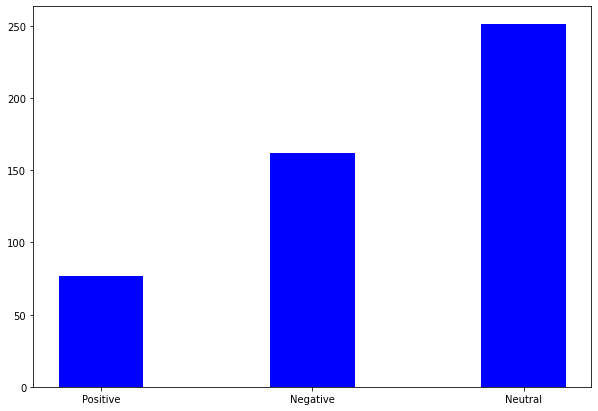

In [17]:
n_pos_sent = len(Scores_Uber_Review[Scores_Uber_Review['compound'] > 0.5])
n_neg_sent = len(Scores_Uber_Review[Scores_Uber_Review['compound'] < -0.5])
n_neu_sent = len(Scores_Uber_Review[(Scores_Uber_Review['compound'] > -0.5) & (Scores_Uber_Review['compound'] < 0.5)])
n_sent = {'Positive':n_pos_sent, 'Negative':n_neg_sent, 'Neutral':n_neu_sent}

plt.figure(figsize = (10, 7))
sentiment = list(n_sent.keys())
sent_values = list(n_sent.values())

plt.bar(sentiment,sent_values,color ='blue',width = 0.4)

In [18]:
from wordcloud import WordCloud

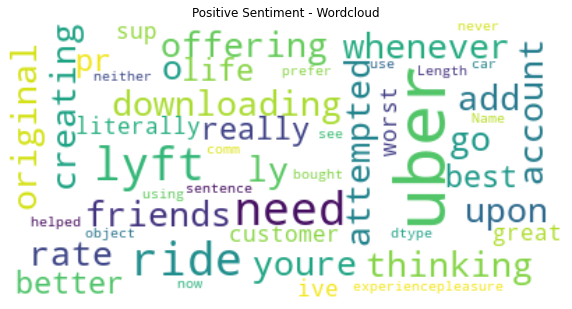

In [19]:
#Generating word clous for positive sentiments
positive_reviews = Scores_Uber_Review['sentence'][Scores_Uber_Review["Polarity"] == 'Positive']

positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(positive_reviews))

plt.figure(figsize = (10, 7))
plt.title("Positive Sentiment - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

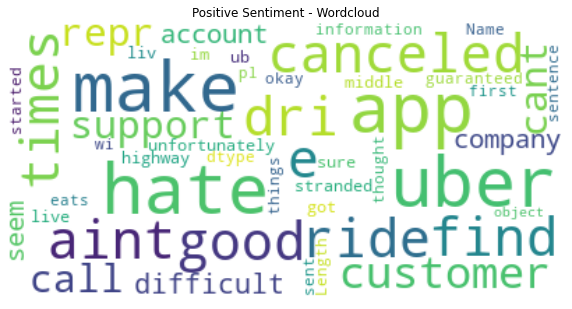

In [20]:
#Generating word clous for Negative sentiments
negative_reviews = Scores_Uber_Review['sentence'][Scores_Uber_Review["Polarity"] == 'Negative']

positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(negative_reviews))

plt.figure(figsize = (10, 7))
plt.title("Positive Sentiment - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

In [21]:
stopwords_eng = stopwords.words("English")

In [22]:
Uber_reviews["Review_words"] = Uber_reviews["Review"].apply(word_tokenize)
Uber_reviews["Review_words"]

0      [for, half, an, hour, we, tried, every, uber, ...
1      [if, im, not, eligible, for, the, offer, stop,...
2      [consistently, inaccurate, uber, eats, eta, an...
3      [i, had, my, rides, canceled, back, to, back, ...
4      [two, of, the, same, orders, was, added, by, a...
                             ...                        
485    [perd, mi, cuenta, no, la, puedo, recuperar, l...
486    [still, the, same, i, was, forced, to, use, it...
487    [it, is, a, 30, minute, commute, from, my, hou...
488    [was, sent, a, 30, off, uber, eats, i, thought...
489    [at, first, uber, was, okay, but, than, things...
Name: Review_words, Length: 490, dtype: object

In [23]:
#Generic function for generating any no. of grams based on the input n

def token_ngrams(sent, n):
    n_grams = ngrams(sent, n)
    return [ ' '.join(grams) for grams in n_grams]

In [24]:
#Generating bi-grams using the above function token_ngrams
bi_grams = Uber_reviews['Review_words'].apply(lambda row: list(token_ngrams(row,2)))
print(bi_grams)
len(bi_grams)

0      [for half, half an, an hour, hour we, we tried...
1      [if im, im not, not eligible, eligible for, fo...
2      [consistently inaccurate, inaccurate uber, ube...
3      [i had, had my, my rides, rides canceled, canc...
4      [two of, of the, the same, same orders, orders...
                             ...                        
485    [perd mi, mi cuenta, cuenta no, no la, la pued...
486    [still the, the same, same i, i was, was force...
487    [it is, is a, a 30, 30 minute, minute commute,...
488    [was sent, sent a, a 30, 30 off, off uber, ube...
489    [at first, first uber, uber was, was okay, oka...
Name: Review_words, Length: 490, dtype: object


490

In [25]:
Uber_reviews["Review_words"] = Uber_reviews["Review_words"].apply(lambda x: ' '.join([w for w in x if w not in (stopwords_eng)]))
Uber_reviews["Review_words"]

0      half hour tried every uber service take short ...
1      im eligible offer stop flooding email false in...
2      consistently inaccurate uber eats eta food men...
3      rides canceled back back still charged account...
4      two orders added accident restaurant tried rem...
                             ...                        
485    perd mi cuenta la puedo recuperar la use el ma...
486    still forced use colombia since know ride shar...
487    30 minute commute household worksite tend use ...
488    sent 30 uber eats thought placing order applie...
489    first uber okay things started happening like ...
Name: Review_words, Length: 490, dtype: object

In [26]:
import itertools
bigrams = []
bigrams = list(itertools.chain(*bi_grams))
bigram_counts = Counter(bigrams)
bigram_counts.most_common(20)

[('a ride', 116),
 ('i have', 99),
 ('the app', 94),
 ('to get', 84),
 ('i was', 76),
 ('and i', 74),
 ('for a', 65),
 ('of the', 60),
 ('this app', 60),
 ('when i', 58),
 ('me to', 57),
 ('i had', 55),
 ('in the', 52),
 ('customer service', 50),
 ('for the', 48),
 ('to be', 47),
 ('a driver', 46),
 ('the driver', 46),
 ('to the', 45),
 ('this is', 43)]

In [27]:
# Stemming using the libraries PorterStemmer
for i in range(len(Uber_reviews['Review'])):
    words  = nltk.tokenize.WhitespaceTokenizer().tokenize(Uber_reviews['Review'][i])
df = pd.DataFrame()
df['OriginalWords'] = pd.Series(words)
#porter's stemmer
porterStemmedWords = [nltk.stem.PorterStemmer().stem(word) for word in words]
df['PorterStemmedWords'] = pd.Series(porterStemmedWords)
#SnowBall stemmer
snowballStemmedWords = [nltk.stem.SnowballStemmer("english").stem(word) for word in words]
df['SnowballStemmedWords'] = pd.Series(snowballStemmedWords)
df

,OriginalWords,PorterStemmedWords,SnowballStemmedWords
0,at,at,at
1,first,first,first
2,uber,uber,uber
3,was,wa,was
4,okay,okay,okay
...,...,...,...
148,so,so,so
149,im,im,im
150,done,done,done
151,using,use,use


In [28]:
# Generating word level DTM matrix

Cv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
tf = Cv.fit_transform(Uber_reviews["Review_words"])
dtm_Uber_reviews = pd.DataFrame(tf.toarray())
#print("Vocabulary: ", Cv.vocabulary_)
dtm_Uber_reviews.head()

,0,1,2,3,4,5,6,7,8,9,...,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Generating word level TF-IDF matrix

tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_Uber_reviews = pd.DataFrame(tfidf.fit_transform(Uber_reviews["Review_words"]).toarray(),columns=tfidf.get_feature_names())
#print("Vocabulary: ", tfidf.vocabulary_)
tfidf_Uber_reviews.head()

,0,010,01182020,05,050,1,10,100,1012,1015,...,youll,young,youre,youve,youworst,yu,zero,zone,zoom,zooms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. Supervised Learning phase: Rubber meets road now. Run a regression (or classification, if you prefer) of review ratings against the text features you have collected in the previous step. Use any regression or classification method you want to. OLS regression is easy to run and interpret, and is hence preferable

In [56]:
# split the Data into training, testing and validation datasets 
X_train, X_test, y_train, y_test = model_selection.train_test_split(Uber_reviews['Review'], Uber_reviews['Rating'],test_size =0.2)

# After splitting into train and test set, get the validation set from the train set
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train,test_size =0.25)


In [57]:
## Defining a general function for generating DTMs by top n tokens

def series2dtm(series0, min_df1=5, ngram_range1=(1,2), top_n=200):

    # Generate DTM matrix
    tf_vect = CountVectorizer(lowercase=False, min_df=min_df1, ngram_range=ngram_range1)
    dtm_tf = tf_vect.fit_transform(series0)
 
    # Reduce the DTM matrix to top n terms
    pd0 = pd.Series(dtm_tf.sum(axis=0).tolist()[0])
    ind0 = pd0.sort_values(ascending=False).index.tolist()[:top_n]
    feat0 = pd.Series(tf_vect.get_feature_names()).iloc[ind0]
    dtm_tf1 = dtm_tf[:,ind0].todense()
    dtm_df = pd.DataFrame(data=dtm_tf1, columns=feat0.tolist())

    # Generate TF-IDF matrix
    idf_vect = TfidfVectorizer(lowercase=False, min_df=min_df1, ngram_range=ngram_range1)
    dtm_idf = idf_vect.fit_transform(series0)

    # Reduce the TF-IDF matrix to top n terms
    pd0 = pd.Series(dtm_idf.sum(axis=0).tolist()[0])
    ind0 = pd0.sort_values(ascending=False).index.tolist()[:top_n]
    feat0 = pd.Series(idf_vect.get_feature_names()).iloc[ind0]
    dtm_idf1 = dtm_idf[:,ind0].todense()
    dtm_idf = pd.DataFrame(data=dtm_idf1, columns=feat0.tolist())

    return(dtm_df, dtm_idf)

In [58]:
from sklearn.linear_model import LogisticRegression

Uber_reviews_Logi = LogisticRegression(max_iter=15000,random_state=0, solver='liblinear')

dtm_tf_valid, dtm_idf_valid = series2dtm(X_valid, min_df1=5, ngram_range1=(1,2), top_n=200)
dtm_tf_train, dtm_idf_train = series2dtm(X_train, min_df1=5, ngram_range1=(1,2), top_n=len(dtm_tf_valid.columns))

Uber_reviews_Logi.fit(dtm_tf_train, y_train)

y_valid_pred = Uber_reviews_Logi.predict(dtm_tf_valid)

# Accuracy on Validation set

score =accuracy_score(y_valid,y_valid_pred)
print("Accuracy score: %.4f\n" % score)

Accuracy score: 0.7551



In [59]:
dtm_tf_test, dtm_idf_test = series2dtm(X_test, min_df1=5, ngram_range1=(1,2), top_n=200)

In [60]:
# Accuracy on Test set

y_test_pred = Uber_reviews_Logi.predict(dtm_tf_test)

score =accuracy_score(y_test,y_test_pred)
print("Accuracy score: %.4f\n" % score)

Accuracy score: 0.6122



In [61]:
# Trying the TF-IDF for training and prediction
from sklearn.linear_model import LogisticRegression

Uber_reviews_Logi = LogisticRegression(max_iter=15000,random_state=0, solver='liblinear')

dtm_tf_valid, dtm_idf_valid = series2dtm(X_valid, min_df1=5, ngram_range1=(1,2), top_n=200)
dtm_tf_train, dtm_idf_train = series2dtm(X_train, min_df1=5, ngram_range1=(1,2), top_n=len(dtm_idf_valid.columns))

Uber_reviews_Logi.fit(dtm_idf_train, y_train)

y_valid_pred = Uber_reviews_Logi.predict(dtm_idf_valid)

# Accuracy on Validation set

score =accuracy_score(y_valid,y_valid_pred)
print("Accuracy score: %.4f\n" % score)

Accuracy score: 0.8163



In [62]:
# Accuracy on Test set for TF-IDF

y_test_pred = Uber_reviews_Logi.predict(dtm_idf_test)

score =accuracy_score(y_test,y_test_pred)
print("Accuracy score: %.4f\n" % score)

Accuracy score: 0.7143

